In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mesa_tricks.io import read_track, read_freqs
from mesa_tricks.utils import memoise, match_modes

### Observational data

> We ended up with 14 frequencies of degree l=0 and l=1 (attached). The peak-bagging teams had a lot of trouble identifying the l=2 modes, so one of our aims is to provide some guidance on the delta nu02 spacing from our initial modeling results. A second round may follow.

> We will adopt spectroscopic constraints from Brewer+2016 (with errors inflated to the systematic noise floor), and the Gaia DR3 luminosity from Keivan's SED analysis:

> Teff = 5901 +/- 78 K  
[M/H] = +0.04 +/- 0.07 dex  
L = 1.992 +/- 0.023 Lsun

> If your fitting method uses estimates of the global oscillation parameters, we will adopt those from Dan's pySYD fit:

> nu_max = 1850 +/- 47 muHz  
Delta nu = 89.5 +/- 0.5 muHz

> Considering our schedule constraints, let's set the deadline for sending your results to three weeks from today, Thursday September 22. Please include the predicted mean small frequency separation (delta nu_02) in your results, along with the radius, mass, age, and whatever other properties you can constrain.

> Let me know if you have any questions.



In [2]:
props_obs = {
    'effective_T': 5901, 'e_effective_T': 78,
    'FeH': 0.04, 'e_FeH': 0.07,
    'luminosity': 1.992, 'e_luminosity': 0.023,
    'nu_max': 1850, 'e_nu_max': 47,
    'Δν': 89.5, 'e_Δν': 0.5
}

In [3]:
data = np.loadtxt("lamSer.txt")
modes_obs = {
    'l': data[:,0], 'ν': data[:, 1], 'e_ν': data[:, 2]
}

# modes_obs['n'] = np.round(modes_obs['ν'] / props_obs['Δν'] - modes_obs['l']/2)

In [4]:
# Direct method M and R

def direct_method(nu_max, Δν, effective_T, **kwargs):
    M = (nu_max / 3090)**3 / (Δν / 135)**4 * np.power(effective_T/5777, 3/2)
    R = (nu_max / 3090)**1 / (Δν / 135)**2 * np.power(effective_T/5777, 1/2)
    print(f"M = {M:.3f}; R = {R:.3f}")
    
direct_method(**props_obs)

M = 1.147; R = 1.377


In [46]:
from os import system
from os.path import isdir, isfile
from mesa_tricks.opt import Δν_fit
from mesa_tricks.costs import bgcost
import warnings

GS98_ZX = 0.0229
GYRE_DIR = "~/Git/gyre"

def pulse(gyrefile):

    outname = gyrefile.replace(".data.GYRE", ".freqs")
    if not isfile(outname):
        with open("gyre.template", 'r') as f:
            template = f.read()

        output = template.format(fname=gyrefile,
                                 outname=outname)

        with open("gyre.in", "w") as f:
            f.write(output)

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            system(f"{GYRE_DIR}/bin/gyre ./gyre.in &> /dev/null")

    return read_freqs(outname)

def χ2_seis_single(track, profile, props=False, trace=False):
    modes = pulse(f"tracks/LOGS_{track}/profile{profile}.data.GYRE")
    
    m0 = modes['l'] == 0
    ν0 = modes['ν'][m0]
    n0 = modes['n_p'][m0]
    Δν_model, *_ = Δν_fit(ν0, n0)
    
    if props:
        
        m2 = modes['l'] == 2
        ν2 = modes['ν'][m2]
        n2 = modes['n_p'][m2]

        dν2 = []

        for n, ν in zip(n0, ν0):
            i = np.where(n2 == (n - 1))[0]
            if len(i) == 1:
                dν2.append(ν - ν2[i])

        return Δν_model, np.median(dν2)
    
    if np.abs(Δν_model - props_obs['Δν']) > props_obs['Δν'] / len(ν0):
        return np.inf
    
    matched = match_modes(modes_obs, modes)
    if len(matched['ν_obs']) != len(modes_obs['ν']):
        return np.inf

    χ2_bg14, _ = bgcost(
        ν_obs=matched['ν_obs'], e_obs=matched['e_obs'],
        ν_model=matched['ν_model'], inertia=matched['E'],
        l=matched['ll'], l0_only=True, trace=trace
    )
    
    return χ2_bg14

def χ2_spec(props):
    return sum((props_obs[_] - props[_])**2 / props_obs[f"e_{_}"]**2
               for _ in props_obs if _[:2] != 'e_' and _ != 'Δν')

def safe_apply(ufunc, arr, *args, **kwargs):
    try:
        return ufunc(arr, *args, **kwargs)
    except ValueError:
        return np.full_like(arr, np.nan)

@memoise
def cost(*params, ID=0, reset=False, trace=False, props=False):
    
    M, Y, Z, α_mlt = params

    if reset or not isdir(f"tracks/LOGS_{ID}"):
        system(f"./dispatch.sh {ID} {M} {Y} {Z} {α_mlt} >| logs/{ID}.mesa.log")
        
    try:
        track = read_track(f"tracks/LOGS_{ID}")
    except FileNotFoundError:
        return np.inf

    track['FeH'] = track['log_surf_cell_z'] - track['log_surface_h1'] - np.log10(GS98_ZX)
    
    spec = np.array(χ2_spec(track))
    seis = np.array([χ2_seis_single(ID, profile) for profile in track.profile])
    
    χ2_total = spec + seis
    
    if trace:
        i0 = np.argmin(χ2_total)
        χ2_seis_single(ID, np.array(track.profile)[i0], trace=True)
        
    if props:
        
        seis_props = np.array([χ2_seis_single(ID, profile, props=True) for profile in track.profile])
        return {
            'χ2_spec': spec,
            'χ2_seis': seis,
            'χ2_total': χ2_total,
            
            # stellar properties of interest
            
            'δν02': seis_props[:,1],
            'M': np.array(track['star_mass']),
            'R': np.power(10, np.array(track['log_R'])),
            't': np.array(track['star_age']),
            'Mconv': np.array(track['mass_conv_core']),
            'Y': np.full(len(track), Y),
            'Z': np.full(len(track), Z),
            'α_mlt': np.full(len(track), α_mlt),
            'dt': safe_apply(np.gradient, np.array(track['star_age']))
        }
        
    return np.min(χ2_total)

In [ ]:
from yabox import DE
from tqdm.auto import tqdm

def job(p):
    return cost(*p)

problem = DE(job, [[1.05, 1.25], [0.248, 0.32], [0.005, 0.04], [1.5, 2.0]],
             maxiters=100, seed=42)
soln = problem.solve(show_progress=True)

Optimizing (DE):   0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
soln

(array([[1.13134886, 0.26242069, 0.02244727, 1.72023639]]), 1.9606136815653175)

In [ ]:
store = np.load("memo.npy", allow_pickle=True)[()]
params = np.array(list(store.keys()))


acc = [cost(*p, props=True) for p in tqdm(params)]
keys = list(acc[0].keys())

In [51]:
props_consolidated = {_: np.concatenate([a[_] for a in acc if a != np.inf]) for _ in acc[0]}
np.save("props.npy", props_consolidated)

### Estimate sampling function

In [128]:
from scipy.stats import gaussian_kde

k = gaussian_kde(params.T)

sampling_function = k(
    np.array([props_consolidated['M'],
    props_consolidated['Y'],
    props_consolidated['Z'],
    props_consolidated['α_mlt']])
)
sampling_function = sampling_function / props_consolidated['dt']

In [129]:
inv_sampling_function = np.nan_to_num(1/sampling_function)

In [102]:
%load_ext autoreload
%autoreload 1
%aimport mesa_tricks.plots.posterior
corner = mesa_tricks.plots.posterior.corner_comparison_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


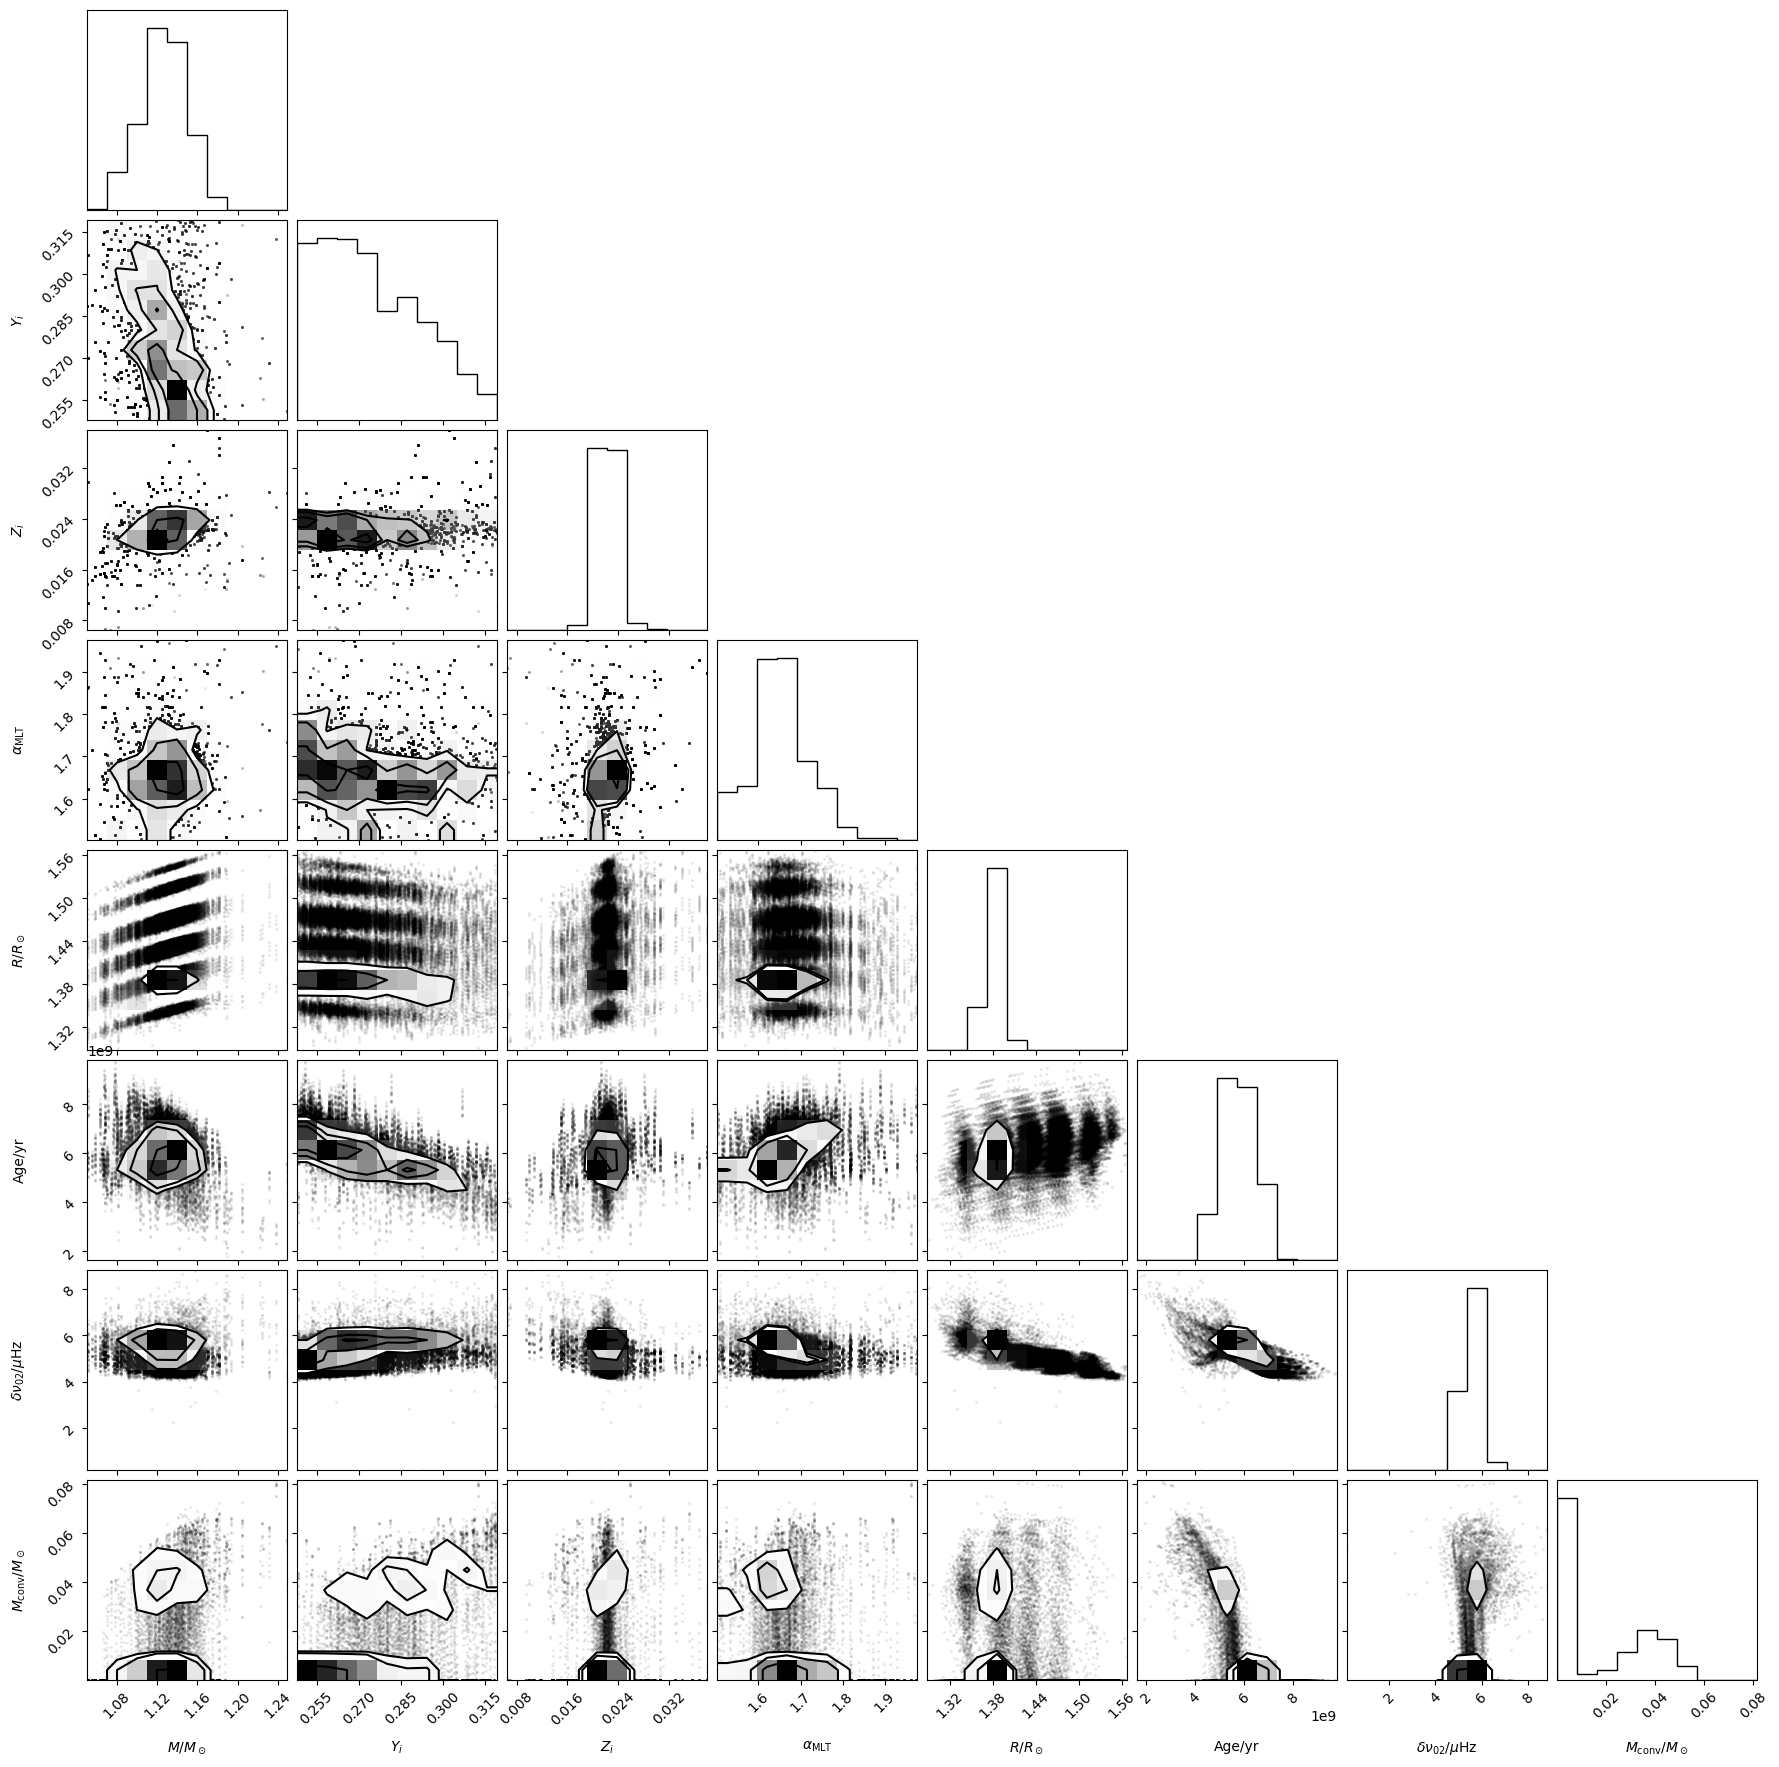

In [132]:
likelihood_weights = np.nan_to_num(inv_sampling_function * np.exp(-props_consolidated['χ2_total']/2))

from corner import corner

plt.close('all')
m_support = (likelihood_weights > 0)
corner(
    np.array([props_consolidated[_][m_support] for _ in ['M', 'Y', 'Z', 'α_mlt', 'R', 't', 'δν02', 'Mconv']]).T,
    weights=likelihood_weights[m_support],
    bins=10,
    labels=['$M/M_\\odot$', "$Y_i$", "$Z_i$", "$\\alpha_\mathrm{MLT}$", "$R/R_\\odot$", "Age/yr",
            '$\\delta\\nu_{02}/\mu$Hz', "$M_\mathrm{conv}/M_\\odot$"]
)
plt.savefig(r"corner_01_ong.png", bbox_inches='tight', transparent=True, dpi=150)
plt.show()

In [76]:
from wquantiles import quantile

In [131]:
from scipy.stats import norm

with open("lambda_ser_ong_l01.txt", 'w') as f:
    def fprint(*a, **b):
        print(*a, **b)
        f.write(*a, **b)
        f.write("\n")

    q0 = [norm.cdf(_) for _ in (-1, 0, 1)]
    for _ in ['M', 'Y', 'Z', 'α_mlt', 'R', 't', 'δν02']:
        qs = [quantile(props_consolidated[_], likelihood_weights, __) for __ in q0]
        if _ == 't':
            qs = [__/1e9 for __ in qs]
        fprint("{}: {:.3e}, {:.3e}, {:.3e}".format(_, *qs))

    # probability of M_conv

    _ = "Mconv"
    m_conv = props_consolidated['Mconv'] > 0
    fprint("p(convective core): {:.3f}".format(np.sum(likelihood_weights[m_conv]) / np.sum(likelihood_weights)))
    qs = [quantile(props_consolidated[_][m_conv], likelihood_weights[m_conv], __) for __ in q0]
    fprint("{}: {:.3e}, {:.3e}, {:.3e}".format(_, *qs))

M: 1.101e+00, 1.128e+00, 1.149e+00
Y: 2.555e-01, 2.722e-01, 2.931e-01
Z: 2.078e-02, 2.226e-02, 2.327e-02
α_mlt: 1.592e+00, 1.647e+00, 1.720e+00
R: 1.371e+00, 1.382e+00, 1.393e+00
t: 5.018e+00, 5.750e+00, 6.541e+00
δν02: 5.255e+00, 5.480e+00, 5.714e+00
p(convective core): 0.455
Mconv: 2.588e-02, 3.827e-02, 4.615e-02
